# Лабораторная работа 3
## Реализация алгоритма обратного распространения ошибки

## Выполнил: __Щеткин Дмитрий Сергеевич__

группа 2.1


**Цель:** Реализовать с нуля полносвязную нейронную сеть на Python с использованием объектно-ориентированного подхода и обучить её с помощью алгоритма обратного распространения ошибки на мини-батчах.

**Задачи:**
1. Реализовать класс `NeuralNetwork`.
2. Реализовать функции активации (Sigmoid, ReLU, Tanh) и их производные.
3. **ЗАПОЛНИТЬ:** Реализовать методы прямого распространения (`_forward`).
4. **ЗАПОЛНИТЬ:** Реализовать метод вычисления функции потерь (`_compute_cost`).
5. **ЗАПОЛНИТЬ:** Реализовать метод обратного распространения ошибки (`_backward`).
6. **ЗАПОЛНИТЬ:** Реализовать метод обновления параметров (`_update_parameters`).
7. **ЗАПОЛНИТЬ:** Реализовать метод обучения (`fit`) с использованием мини-батчей.
8. **ЗАПОЛНИТЬ:** Реализовать метод предсказания (`predict`).
9. Протестировать реализацию на простом наборе данных.

## 1. Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

## 2. Реализация вспомогательных функций и класса нейронной сети

Ниже приведены вспомогательные функции активации и структура класса `NeuralNetwork`. Вам необходимо заполнить пропущенные части в методах класса.

In [2]:
# ====================================
# Вспомогательные функции активации
# ====================================

def sigmoid(z):
    """Сигмоидная функция активации."""
    # Добавляем защиту от переполнения
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Производная сигмоидной функции."""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU функция активации."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Производная ReLU функции."""
    return np.where(z > 0, 1.0, 0.0) # Используем float

def tanh(z):
    """Гиперболический тангенс функция активации."""
    return np.tanh(z)

def tanh_derivative(z):
    """Производная гиперболического тангенса."""
    return 1 - np.tanh(z)**2

# Словарь для доступа к функциям активации и их производным по имени
ACTIVATIONS = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative)
}

# ====================================
# Класс нейронной сети
# ====================================

class NeuralNetwork:
    """Класс полносвязной нейронной сети с обучением по mini-batches."""

    def __init__(self, layer_dims, activation_funcs, learning_rate=0.01):
        """Инициализация нейронной сети.

        Args:
            layer_dims (list): Список с количеством нейронов в каждом слое
                               (включая входной и выходной).
                               Пример: [input_size, hidden1_size, hidden2_size, output_size]
            activation_funcs (list): Список с названиями функций активации для каждого
                                     скрытого и выходного слоя (длина = len(layer_dims) - 1).
                                     Пример: ['relu', 'relu', 'sigmoid']
            learning_rate (float): Скорость обучения.
        """
        if len(layer_dims) < 2:
            raise ValueError("Сеть должна иметь как минимум входной и выходной слои.")
        if len(activation_funcs) != len(layer_dims) - 1:
            raise ValueError("Количество функций активации должно соответствовать количеству слоев (исключая входной).")

        self.num_layers = len(layer_dims)
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.parameters = {} # Словарь для хранения весов (W) и смещений (b)
        self.activation_funcs = {} # Словарь для хранения функций активации и их производных

        # Инициализация весов и смещений
        np.random.seed(42) # Для воспроизводимости
        for l in range(1, self.num_layers):
            # Инициализация He для ReLU, Xavier/Glorot для tanh/sigmoid
            if activation_funcs[l-1] == 'relu':
                # He initialization
                self.parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2. / layer_dims[l-1])
            else:
                # Xavier/Glorot initialization
                limit = np.sqrt(6. / (layer_dims[l-1] + layer_dims[l]))
                self.parameters[f'W{l}'] = np.random.uniform(-limit, limit, (layer_dims[l], layer_dims[l-1]))

            # Инициализация смещений нулями
            self.parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))

            # Сохранение функций активации
            activation_name = activation_funcs[l-1]
            if activation_name not in ACTIVATIONS:
                raise ValueError(f"Неизвестная функция активации: {activation_name}")
            self.activation_funcs[l] = ACTIVATIONS[activation_name]

    def _forward(self, X):
        """Прямое распространение для одного мини-батча.

        Args:
            X (np.array): Входные данные мини-батча (размер: input_size x batch_size).

        Returns:
            tuple: Кортеж с выходом сети (A_last) и кешем промежуточных значений (Z, A).
        """
        cache = {}
        A = X
        cache["A0"] = A # Сохраняем входные данные как активацию 0-го слоя

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Цикл по слоям от 1 до L (num_layers - 1)
        for l in range(1, self.num_layers):
            # Получение параметров W и b для текущего слоя l
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']

            # Получение функции активации для текущего слоя l
            activation_func, _ = self.activation_funcs[l]

            # Получение активаций предыдущего слоя (A^{l-1})
            A_prev = A # В первой итерации A = X (A0), в следующих - активации предыдущего слоя

            # Шаг 1: Вычисление линейной части (Z^l = W^l * A^{l-1} + b^l)
            # Используйте np.dot для матричного умножения
            Z = np.dot(W, A_prev) + b

            # Шаг 2: Вычисление активации (A^l = h_l(Z^l))
            A = activation_func(Z)

            # Шаг 3: Сохранение промежуточных значений в кеш
            # Сохраните Z, A для текущего слоя l
            # Ключи: f'Z{l}', f'A{l}'
            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A
            # A_prev уже сохранен как A{l-1} в предыдущей итерации или как A0 в начале
        # --- КОНЕЦ ВАШЕГО КОДА ---

        A_last = A # Последнее значение A - это выход сети
        return A_last, cache

    def _compute_cost(self, A_last, Y):
        """Вычисление функции потерь (перекрестная энтропия для бинарной классификации).

        Args:
            A_last (np.array): Выход сети (активации последнего слоя) (размер: output_size x batch_size).
            Y (np.array): Истинные метки (размер: output_size x batch_size).

        Returns:
            float: Значение функции потерь.
        """
        m = Y.shape[1] # Размер мини-батча
        epsilon = 1e-8 # Для численной стабильности логарифма

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Шаг 1: Вычислите стоимость с использованием формулы перекрестной энтропии
        # cost = -(1/m) * sum(Y * log(A_last + epsilon) + (1 - Y) * log(1 - A_last + epsilon))
        # Используйте np.sum
        cost = -(1/m) * np.sum(Y * np.log(A_last + epsilon) + (1 - Y) * np.log(1 - A_last + epsilon))
        # --- КОНЕЦ ВАШЕГО КОДА ---

        cost = np.squeeze(cost) # Убираем лишние размерности, если они есть
        assert(cost.shape == ()) # Убедимся, что cost - скаляр

        return cost

    def _backward(self, A_last, Y, cache):
        """Обратное распространение ошибки для одного мини-батча.

        Args:
            A_last (np.array): Выход сети (активации последнего слоя).
            Y (np.array): Истинные метки.
            cache (dict): Кеш промежуточных значений из прямого распространения (содержит Z1, A1, Z2, A2, ...).

        Returns:
            dict: Словарь с градиентами dW, db для каждого слоя (ключи: dW1, db1, dW2, db2, ...).
        """
        grads = {}
        m = Y.shape[1] # Размер мини-батча
        L = self.num_layers - 1 # Индекс последнего слоя с параметрами (слои нумеруются с 1)
        epsilon = 1e-8 # Для численной стабильности деления

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Шаг 1: Инициализация обратного распространения (для выходного слоя L)
        # Вычислите производную функции потерь (перекрестная энтропия) по активациям последнего слоя (dA^L)
        # dA_last = - (Y / (A_last + epsilon) - (1 - Y) / (1 - A_last + epsilon))
        dA_last = - (Y / (A_last + epsilon) - (1 - Y) / (1 - A_last + epsilon))

        # Шаг 2: Градиенты для выходного слоя L
        # Получите Z^L и A^{L-1} из кеша
        Z_last = cache[f'Z{L}']
        A_prev = cache[f'A{L-1}']

        # Получите производную функции активации для слоя L
        _, activation_derivative = self.activation_funcs[L]

        # Вычислите dZ^L = dA^L * h_L'(Z^L)
        dZ_last = dA_last * activation_derivative(Z_last)

        # Вычислите градиенты dW^L = (1/m) * dZ^L * (A^{L-1})^T и db^L = (1/m) * sum(dZ^L, axis=1)
        # Используйте np.dot для матричного умножения и np.sum для суммирования по оси батчей
        grads[f'dW{L}'] = (1 / m) * np.dot(dZ_last, A_prev.T)
        grads[f'db{L}'] = (1 / m) * np.sum(dZ_last, axis=1, keepdims=True)

        # Вычислите dA^{L-1} = (W^L)^T * dZ^L (для передачи на предыдущий слой)
        # Получите W^L из self.parameters
        W_last = self.parameters[f'W{L}']
        dA_prev = np.dot(W_last.T, dZ_last)

        # Шаг 3: Цикл по скрытым слоям (в обратном порядке от L-1 до 1)
        for l in range(L-1, 0, -1):
            # Получите Z^l и A^{l-1} из кеша
            Z = cache[f'Z{l}']
            A_prev_l = cache[f'A{l-1}']

            # Получите производную функции активации для слоя l
            _, activation_derivative = self.activation_funcs[l]

            # Вычислите dZ^l = dA^{l} * h_l'(Z^l) (dA^{l} - это dA_prev из предыдущей итерации)
            dZ = dA_prev * activation_derivative(Z)

            # Вычислите градиенты dW^l = (1/m) * dZ^l * (A^{l-1})^T и db^l = (1/m) * sum(dZ^l, axis=1)
            grads[f'dW{l}'] = (1 / m) * np.dot(dZ, A_prev_l.T)
            grads[f'db{l}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

            # Вычислите dA^{l-1} = (W^l)^T * dZ^l (для передачи на предыдущий слой)
            # Получите W^l из self.parameters
            W_current = self.parameters[f'W{l}']
            dA_prev = np.dot(W_current.T, dZ)
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return grads

    def _update_parameters(self, grads):
        """Обновление весов и смещений.

        Args:
            grads (dict): Словарь с градиентами dW, db (ключи: dW1, db1, dW2, db2, ...).
        """
        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Цикл по слоям от 1 до L
        for l in range(1, self.num_layers):
            # Обновите параметры W^l и b^l, используя градиенты из grads и скорость обучения
            # W^l = W^l - learning_rate * dW^l
            # b^l = b^l - learning_rate * db^l
            self.parameters[f'W{l}'] = self.parameters[f'W{l}'] - self.learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] = self.parameters[f'b{l}'] - self.learning_rate * grads[f'db{l}']
        # --- КОНЕЦ ВАШЕГО КОДА ---

    def fit(self, X_train, Y_train, epochs, batch_size, print_cost_every=100):
        """Обучение нейронной сети.

        Args:
            X_train (np.array): Обучающие данные (размер: input_size x num_examples).
            Y_train (np.array): Истинные метки для обучающих данных (размер: output_size x num_examples).
            epochs (int): Количество эпох обучения.
            batch_size (int): Размер мини-батча.
            print_cost_every (int): Печатать значение функции потерь каждые N эпох (0 - не печатать).
        """
        costs = [] # Для отслеживания функции потерь
        m = X_train.shape[1] # Количество обучающих примеров

        np.random.seed(1) # Для воспроизводимости перемешивания

        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Цикл по эпохам
        for epoch in range(epochs):
            epoch_cost = 0.

            # Шаг 1: Перемешивание данных
            # Создайте случайную перестановку индексов от 0 до m-1
            permutation = np.random.permutation(m)
            # Перемешайте X_train и Y_train, используя перестановку
            shuffled_X = X_train[:, permutation]
            shuffled_Y = Y_train[:, permutation]

            # Шаг 2: Определение количества мини-батчей
            num_minibatches = m // batch_size
            if m % batch_size != 0:
                num_minibatches += 1
            # Шаг 3: Цикл по мини-батчам
            for i in range(num_minibatches):
                # Шаг 3.1: Формирование мини-батча (mini_batch_X, mini_batch_Y)
                # Определите начальный и конечный индексы для среза
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, m)
                # Сделайте срез из shuffled_X и shuffled_Y
                mini_batch_X = shuffled_X[:, start_idx:end_idx]
                mini_batch_Y = shuffled_Y[:, start_idx:end_idx]

                # Шаг 3.2: Прямое распространение
                # Вызовите self._forward для mini_batch_X
                A_last, cache = self._forward(mini_batch_X)

                # Шаг 3.3: Вычисление потерь для мини-батча
                # Вызовите self._compute_cost
                batch_cost = self._compute_cost(A_last, mini_batch_Y)
                # Добавьте взвешенную стоимость батча к стоимости эпохи
                epoch_cost += batch_cost * mini_batch_X.shape[1]

                # Шаг 3.4: Обратное распространение
                # Вызовите self._backward
                grads = self._backward(A_last, mini_batch_Y, cache)

                # Шаг 3.5: Обновление параметров
                # Вызовите self._update_parameters
                self._update_parameters(grads)

            # Шаг 4: Вычисление средней стоимости за эпоху
            epoch_cost /= m
            costs.append(epoch_cost)

            # Печать стоимости (каждые print_cost_every эпох)
            if print_cost_every > 0 and (epoch % print_cost_every == 0 or epoch == epochs - 1):
                print(f"Эпоха {epoch}: стоимость = {epoch_cost:.6f}")
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return costs

    def predict(self, X):
        """Предсказание для новых данных.

        Args:
            X (np.array): Входные данные (размер: input_size x num_examples).

        Returns:
            np.array: Предсказанные метки (0 или 1 для бинарной классификации).
        """
        # --- НАЧАЛО ВАШЕГО КОДА ---
        # Шаг 1: Выполните прямое распространение, чтобы получить активации последнего слоя (A_last)
        # Используйте self._forward
        A_last, _ = self._forward(X)

        # Шаг 2: Преобразуйте вероятности A_last в предсказания (0 или 1)
        # Используйте порог 0.5 для бинарной классификации
        predictions = (A_last > 0.5).astype(int)
        # --- КОНЕЦ ВАШЕГО КОДА ---

        return predictions

## 3. Генерация и подготовка данных

Этот блок остается без изменений. Он генерирует данные "две луны".

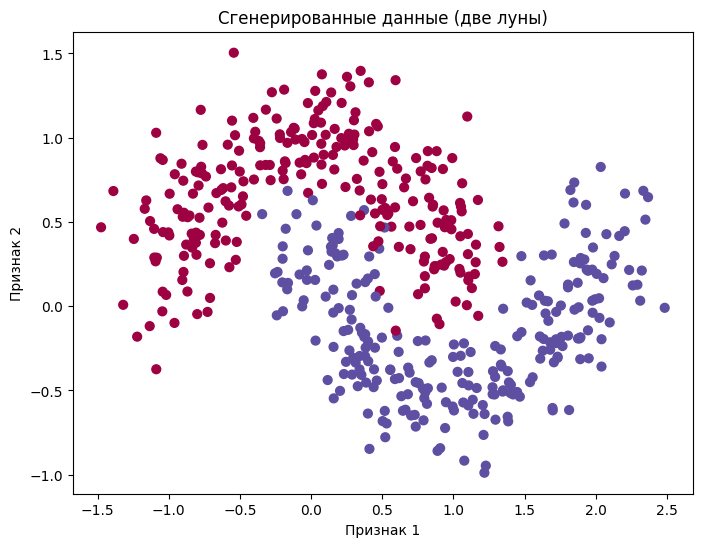

Размерность X_train: (2, 500)
Размерность Y_train: (1, 500)


In [3]:
# Генерация данных
X, Y = make_moons(n_samples=500, noise=0.2, random_state=42)

# Визуализация данных
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.title("Сгенерированные данные (две луны)")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.show()

# Преобразование данных для нашей сети
# Транспонируем X, чтобы признаки были строками, а примеры - столбцами
X_train = X.T
# Преобразуем Y в вектор-строку (1 x num_examples)
Y_train = Y.reshape(1, Y.shape[0])

print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность Y_train: {Y_train.shape}")

## 4. Определение архитектуры и обучение сети

Этот блок остается без изменений. Он определяет параметры сети и запускает обучение. Если ваша реализация верна, вы должны увидеть, как стоимость уменьшается со временем.

In [4]:
# Параметры сети
input_size = X_train.shape[0] # 2 признака
output_size = Y_train.shape[0] # 1 выход (бинарная классификация)
layer_dims = [input_size, 5, 3, output_size] # Архитектура: 2 -> 5 -> 3 -> 1
activation_funcs = ['relu', 'relu', 'sigmoid'] # Функции активации для слоев 1, 2, 3
learning_rate = 0.1
epochs = 10000
batch_size = 64

# Создание и обучение сети
nn = NeuralNetwork(layer_dims, activation_funcs, learning_rate)
costs = nn.fit(X_train, Y_train, epochs, batch_size, print_cost_every=1000)

Эпоха 0: стоимость = 0.694673
Эпоха 1000: стоимость = 0.054785
Эпоха 2000: стоимость = 0.055196
Эпоха 3000: стоимость = 0.051961
Эпоха 4000: стоимость = 0.052535
Эпоха 5000: стоимость = 0.051803
Эпоха 6000: стоимость = 0.051996
Эпоха 7000: стоимость = 0.052894
Эпоха 8000: стоимость = 0.050411
Эпоха 9000: стоимость = 0.051034
Эпоха 9999: стоимость = 0.051785


## 5. Визуализация функции потерь

Этот блок остается без изменений. Он строит график функции потерь.

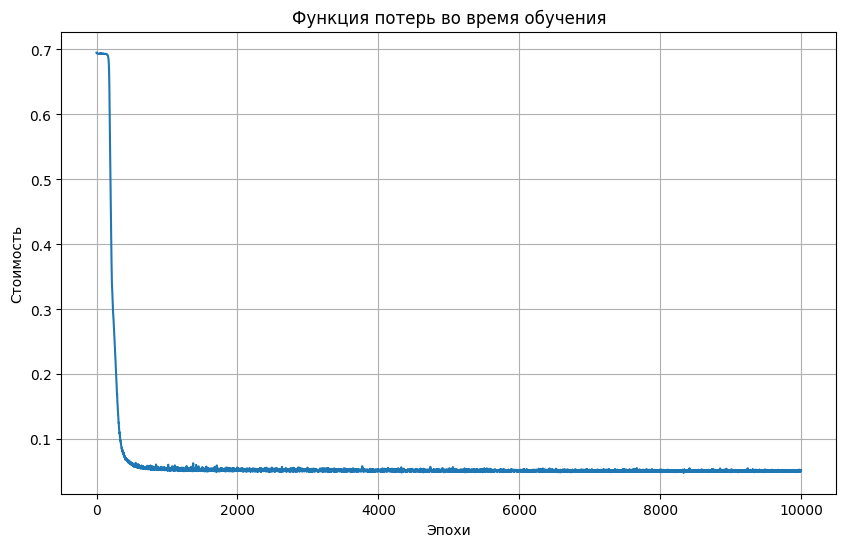

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.title("Функция потерь во время обучения")
plt.xlabel("Эпохи") # Обновлено
plt.ylabel("Стоимость")
plt.grid(True)
plt.show()

## 6. Визуализация границы решений

Этот блок остается без изменений. Он использует вашу реализованную функцию `predict` для построения границы решений.

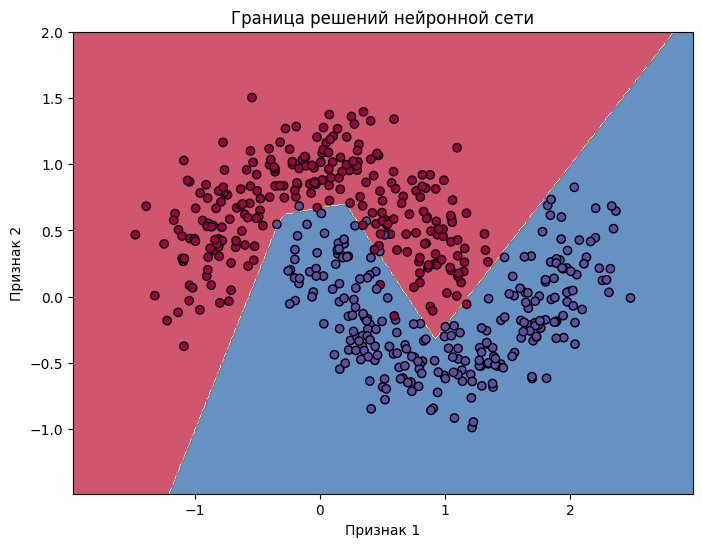

In [6]:
def plot_decision_boundary(model, X, y):
    # Устанавливаем минимальные и максимальные значения и добавляем отступы
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    h = 0.01
    # Генерируем сетку точек с шагом h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Предсказываем значения функции для всей сетки
    # Убедимся, что входные данные для predict имеют правильную форму
    grid_input = np.c_[xx.ravel(), yy.ravel()].T
    Z = model.predict(grid_input)
    Z = Z.reshape(xx.shape)
    # Строим контурный график и отображаем обучающие примеры
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Граница решений нейронной сети")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.show()

# Визуализация границы решений
plot_decision_boundary(nn, X_train, Y_train)

## 7. Оценка точности (Accuracy)

Этот блок остается без изменений. Он использует вашу реализованную функцию `predict` для вычисления точности.

In [7]:
# Получаем предсказания
predictions = nn.predict(X_train)

# Сравниваем предсказания с истинными метками
accuracy = np.mean(predictions == Y_train) * 100

print(f"Точность на обучающем наборе: {accuracy:.2f}%")

Точность на обучающем наборе: 98.00%


## 8. Заключение

Если все блоки кода выполнились без ошибок, и вы видите график функции потерь, границу решений и значение точности, значит, вы успешно реализовали алгоритм обратного распространения ошибки!